# Residual Networks (ResNets):

#### Import packages as earlier:

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,
    Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image 
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import plot_model, get_file, model_to_dot
import tensorflow.keras.backend as K
import pydot
from IPython.display import SVG
K.set_image_data_format('channels_last')

from matplotlib.pyplot import imshow
%matplotlib inline


### 1. The problem of very deep neural networks: 
the issue of gradients either exploding or typically vanishing that we face in shallower layers as the no. of iterations goes on to a certain large value.
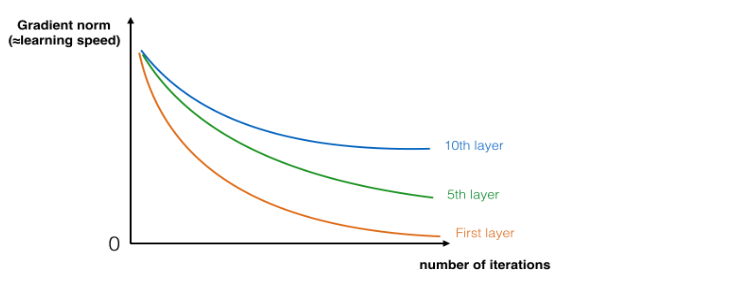

would solve this using resnets (skip-connections)

### 2 Types of blocks:
2.1 The Identity block:

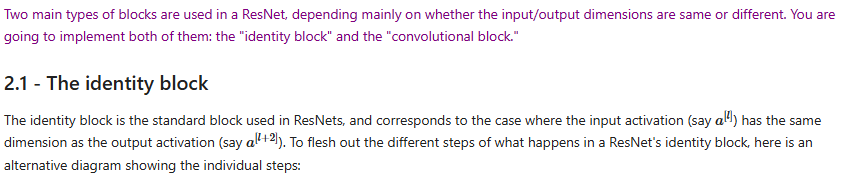

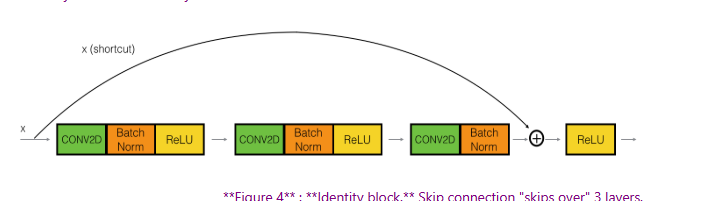


In [8]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    F1, F2, F3 = filters
    X_shortcut = X # this will be passed as per skip connection logic

    X = Conv2D(filters = F1, kernel_size=(1, 1), strides = (1,1), padding='valid', name=conv_name_base + '2a', kernel_initializer="glorot_uniform")(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation("relu")(X)

    X = Conv2D(filters = F2, kernel_size=(1, 1), strides = (1,1), padding='same', name=conv_name_base + '2b', kernel_initializer="glorot_uniform")(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation("relu")(X)

    X = Conv2D(filters = F3, kernel_size=(1, 1), strides = (1,1), padding='valid', name=conv_name_base + '2c', kernel_initializer="glorot_uniform")(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X

    

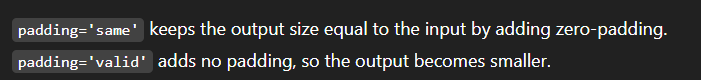

In [9]:
with tf.compat.v1.Session() as test:
    np.random.seed(1)
    A_prev = tf.compat.v1.placeholder(tf.float32, [3, 4, 4, 6])
    x = np.random.randn(3, 4, 4, 6)

    A = identity_block(A_prev, f=2, filters=[2, 4, 6], stage=1, block='a')

    test.run(tf.compat.v1.global_variables_initializer())
    
    out = test.run(A, feed_dict={A_prev: x})
    print("out = " + str(out[1,1,0,:])) 

out = [0.        0.        1.2737559 1.9671017 0.        1.236164 ]


#### 2.2 The Convolutional block:

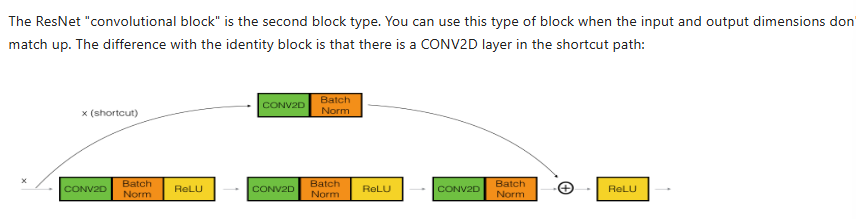

In [6]:
def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    F1, F2, F3 = filters

    X_shortcut = X

    x = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + "2a", kernel_initializer="glorot_uniform")(X)
    x = BatchNormalization(axis=3, name=bn_name_base + "2a")(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + "2b", kernel_initializer="glorot_uniform")(x)
    x = BatchNormalization(axis=3, name=bn_name_base + "2b")(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + "2c", kernel_initializer="glorot_uniform")(x)
    x = BatchNormalization(axis=3, name=bn_name_base + "2c")(x)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + "1", kernel_initializer="glorot_uniform")(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + "1")(X_shortcut)

    X = Add()([x, X_shortcut])
    X = Activation('relu')(X)

    return X

In [7]:
with tf.compat.v1.Session() as test:
    np.random.seed(1)
    A_prev = tf.compat.v1.placeholder(tf.float32, [3, 4, 4, 6])
    x = np.random.randn(3, 4, 4, 6)

    A = convolutional_block(A_prev, f=2, filters=[2, 4, 6], stage=1, block='a')

    test.run(tf.compat.v1.global_variables_initializer())
    
    out = test.run(A, feed_dict={A_prev: x})
    print("out = " + str(out[1,1,0,:])) 

out = [0.11915596 0.         0.41921014 0.         0.         0.2399739 ]


#### 3. Building ResNet model (50 Layers):

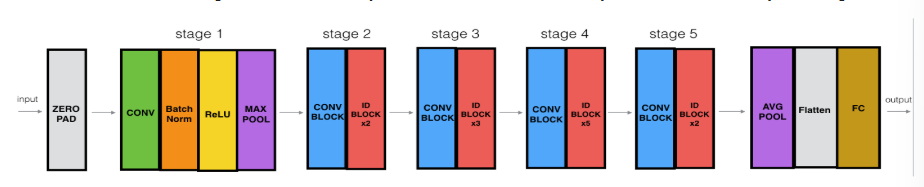

In [13]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
    x_input = Input(input_shape) # define it as a tensor
    
    # zero padding
    x = ZeroPadding2D((3, 3))(x_input) # 3-pixel border of 0's added on all sides
    
    # stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer="glorot_uniform")(x)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #stage 2
    x = convolutional_block(x, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    # stage 3
    x = convolutional_block(x, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    # stage 4
    x = convolutional_block(x, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # stage 5
    x = convolutional_block(x, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    # average pooling
    x = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(x)

    # output layer
    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer="glorot_uniform")(x)

    # Connect everything from X_input to X and treat it as a single model named ResNet50.
    model = Model(inputs=x_input, outputs=x, name='ResNet50')
    return model

In [14]:
model = ResNet50(input_shape=(64, 64, 3), classes=6)

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Loading Dataset:

In [30]:
import h5py
import numpy as np

def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    test_dataset = h5py.File('test_signs.h5', "r")

    X_train_orig = np.array(train_dataset["train_set_x"][:])  # training set features
    Y_train_orig = np.array(train_dataset["train_set_y"][:])  # training set labels

    X_test_orig = np.array(test_dataset["test_set_x"][:])     # test set features
    Y_test_orig = np.array(test_dataset["test_set_y"][:])     # test set labels

    classes = np.array(test_dataset["list_classes"][:])       # list of classes (0–5)

    # reshape labels to (1, number of examples)
    Y_train_orig = Y_train_orig.reshape((1, Y_train_orig.shape[0]))
    Y_test_orig = Y_test_orig.reshape((1, Y_test_orig.shape[0]))

    return X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes


In [31]:
x_train_orig, y_train_orig, x_test_orig, y_test_orig, classes = load_dataset()

In [32]:
def convert_to_one_hot(Y, num_classes):
    # eye creates identity matrix and then so so ...
    return np.eye(num_classes)[Y.reshape(-1)]


In [34]:
x_train = x_train_orig/255.
x_test = x_test_orig/255.

y_train = convert_to_one_hot(y_train_orig, 6)
y_test = convert_to_one_hot(y_test_orig, 6)

print("number of training examples = " + str(x_train.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [35]:
# training...
model.fit(x_train, y_train, epochs=2, batch_size=32)

Epoch 1/2
34/34 ━━━━━━━━━━━━━━━━━━━━ 103s 986ms/step - accuracy: 0.3163 - loss: 2.2648
Epoch 2/2
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7132 - loss: 0.7968


In [36]:
# let's check this on test dataset on how it will perform
preds = model.evaluate(x_test, y_test)
print("loss = " + str(preds[0]))
print("test accuracy = " + str(preds[1]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.1562 - loss: 4.9510
loss = 4.880782127380371
test accuracy = 0.1666666716337204


#### Inference (on your own image):

Input image shape:  (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [[9.08563286e-03 8.79819796e-04 4.62096557e-03 9.69577968e-01
  3.16641206e-04 1.55189065e-02]]


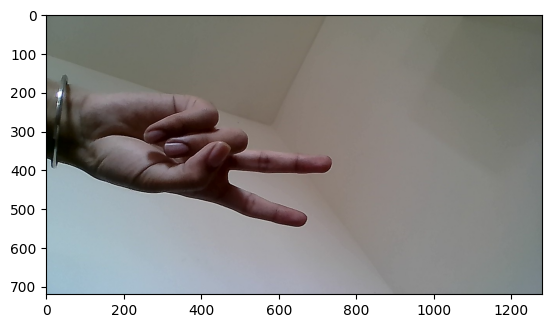

In [37]:
from PIL import Image

img_path = "img1.jpg"
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print("Input image shape: ", x.shape)
my_image = Image.open(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = " + str(model.predict(x)))

In [38]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 70, 70, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │      9,472 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 32, 32,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 32, 32,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a      │ (None, 15, 15,    │      4,160 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a       │ (None, 15, 15,    │        256 │ res2a_branch2a[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 15, 15,    │          0 │ bn2a_branch2a[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b      │ (None, 15, 15,    │     36,928 │ activation_10[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b       │ (None, 15, 15,    │        256 │ res2a_branch2b[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 15, 15,    │          0 │ bn2a_branch2b[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2c      │ (None, 15, 15,    │     16,640 │ activation_11[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch1       │ (None, 15, 15,    │     16,640 │ max_pooling2d[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2c       │ (None, 15, 15,    │      1,024 │ res2a_branch2c[0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch1        │ (None, 15, 15,    │      1,024 │ res2a_branch1[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 15, 15,    │          0 │ bn2a_branch2c[0]

 Total params: 48,870,292 (186.43 MB)

 Trainable params: 16,272,390 (62.07 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 32,544,782 (124.15 MB)

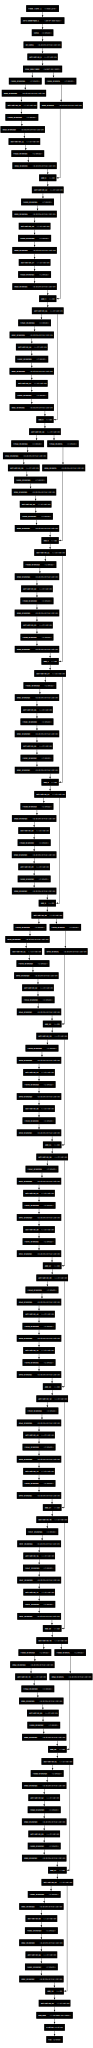

In [39]:
plot_model(model, to_file='resnet50model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

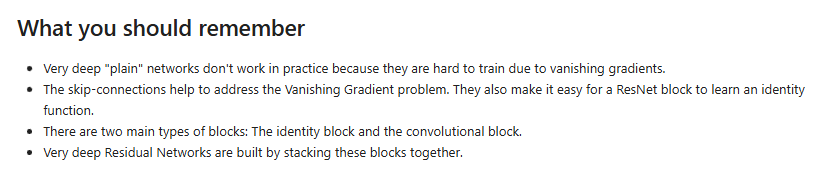

## Finish.